In [1]:
from lmfit import *
from iqtools import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

In [12]:
def get_cut_spectrogram2(xx, yy, zz, xcen=None, xspan=None, ycen=None, yspan=None, invert=False):
    if not xspan:
        xspanmask = (xx[0, :] != 0) | (xx[0, :] == 0)
    else:
        xspanmask = (xx[0, :] <= xcen + xspan /
                     2) & (xx[0, :] >= xcen - xspan / 2)

    if not yspan:
        yspanmask = (yy[:, 0] != 0) | (yy[:, 0] == 0)
    else:
        yspanmask = (yy[:, 0] <= ycen + yspan /
                     2) & (yy[:, 0] >= ycen - yspan / 2)

    if invert:
        xspanmask = np.invert(xspanmask)
        yspanmask = np.invert(yspanmask)

    # need to create a new meshgrid due to cut, otherwise new data won't fit old mesh
    newz = zz[yspanmask][:, xspanmask]
    newx, newy = np.meshgrid(
        np.arange(np.shape(newz)[1]), np.arange(np.shape(newz)[0]))
    if np.shape(yy)[0]==1: delta_y=0
    else: delta_y = yy[1, 0] - yy[0, 0]
    newy = newy * delta_y
    delta_x = xx[0, 1] - xx[0, 0]
    newx = newx - newx[-1, -1] / 2
    newx = newx * delta_x

    return newx, newy, newz

def do_it(filename, lframes, time, skip,xcen,xspan):
    iq = get_iq_object(filename)
    iq.read_samples(1)                                                          
    nframes=int(time*iq.fs/lframes)
    sframes=int(skip*iq.fs/lframes)
    iq.read(nframes=nframes, lframes=lframes, sframes=sframes)
    iq.method='mtm' #'fft', 'mtm', 'welch'                                                                                                                 \                                                                                                       
    xx, yy, zz = iq.get_spectrogram(nframes, lframes) #f=x[t,p], t=y[p,f], p=z[t,f] 
    nxx,nyy,nzz=get_cut_spectrogram2(xx,yy,zz, xcen=xcen, xspan=xspan)
    return nxx,nyy,nzz

def isomer_substract(f,l,t,s,s2,fs):
    xx,yy,zz=do_it(f,l,t,s,s2,fs)
    xx2,yy2,zz2=do_it(f,l,t,s,s2,fs)
    axx,ayy,azz=get_averaged_spectrogram(xx,yy,zz, len(xx[:,0]))
    axxp,ayyp,azzp=get_averaged_spectrogram(xx2,yy2,zz2, len(xx2[:,0]))
    #plt.plot(axx[0,:], azz[0,:])#, #axxp[0,:], azzp[0,:])#, #axxn[0,:], azzn[0,:])
    plot_spectrum(axx[0,:], azz[0,:],dbm=True)
    plt.show()
    return axx[0,:], azz[0,:], axx, ayy, azz

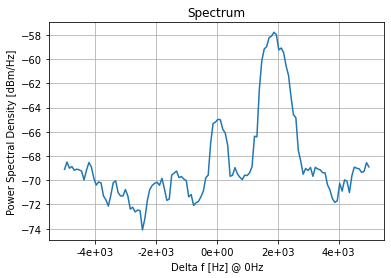

In [13]:
file='/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
x,y,_,_,_=isomer_substract(file,612,0.03,5.09,-2e3,1e4)

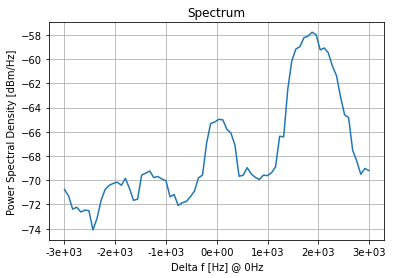

ValueError: too many values to unpack (expected 2)

In [4]:
file='/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.55.25.448.tiq'
x,y, _, _, _=isomer_substract(file,612,0.03,5.09,-2e3,6e3)
gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=6e-07, cen=2e3, wid=2e2)
params = gmodel.make_params()

x2,y2, _, _, _=isomer_substract(file,612,0.03,5.15,-2e3,6e3)
gmodel2 = Model(gaussian)
result2 = gmodel2.fit(y2, x=x2, amp=8e-07, cen=2e3, wid=2e2)
params2 = gmodel2.make_params()

x3,y3, _, _, _=isomer_substract(file,612,0.03,5.2,-2e3,6e3)
gmodel3 = Model(gaussian)
result3 = gmodel3.fit(y3, x=x3, amp=8e-07, cen=2e3, wid=2e2)
params3 = gmodel3.make_params()
print(result.fit_report())

plt.plot(x, y, 'o', label='t0')
#plt.plot(x, result.init_fit, '--', label='initial fit')
#plt.plot(x, result.best_fit, '-', label='best fit')
#print(result.fit_report())
plt.plot(x2, y2, 'o', label='t0+60ms')
#plt.plot(x2, result2.init_fit, '--', label='initial fit')
#plt.plot(x2, result2.best_fit, '-', label='best fit')
plt.plot(x3, y3, 'o', label='t0+100ms')
#plt.plot(x2, result2.init_fit, '--', label='initial fit')
#plt.plot(x3, result3.best_fit, '-', label='best fit')
plt.legend()
#plt.savefig('2022.03.03.decay2.pdf')
plt.show()


In [62]:
gmodel2 = Model(gaussian)
gmodel2.set_param_hint('cen', value=0, min=-1000, max=500)
result2=gmodel2.fit(y, x=x, amp=2.1e-08, cen=50, wid=1e2)
plt.plot(x, result2.init_fit, '--', label='initial fit2')
plt.plot(x, result2.best_fit, '-', label='best fit2')
plt.legend()
plt.show()

{}

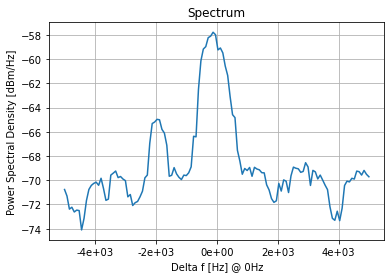

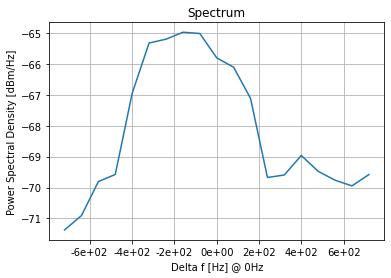

In [109]:
x,y=isomer_substract(file,612,0.03,5.1,0,1e4)
gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=6e-07, cen=0, wid=2e2)
nxcen=result.params['cen'].value
x,y=isomer_substract(file,612,0.03,5.1,-1700+nxcen,1.5e3)

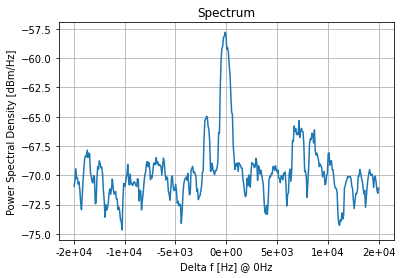

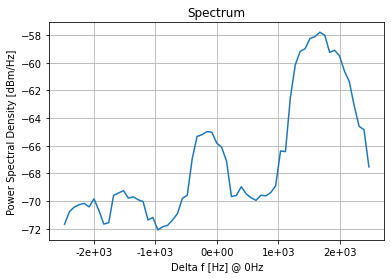

-114.22010395694537

In [142]:
f2='/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.23.54.31.735.tiq'
f3='/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.08.21.18.07.820.tiq'

x,y=isomer_substract(file,612,0.03,5.095,0,3e4)
gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=6e-07, cen=0, wid=2e2)
nxcen=result.params['cen'].value
x,y=isomer_substract(file,612,0.03,5.095,-1700+nxcen,5e3)
nxcen

In [199]:
for value in result.params.values():
    print(value)

<Parameter 'amp', value=1.4370061196963871e-06 +/- 4.91e-08, bounds=[-inf:inf]>
<Parameter 'cen', value=1880.1455484709004 +/- 14.2, bounds=[-inf:inf]>
<Parameter 'wid', value=361.16368445001086 +/- 14.2, bounds=[-inf:inf]>


In [182]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
amp,1.4370e-06,4.9068e-08,(3.41%),6e-07,-inf,inf,True
cen,1880.14555,14.2385389,(0.76%),2000.0,-inf,inf,True
wid,361.163684,14.2430372,(3.94%),200.0,-inf,inf,True


# checking

In [264]:
def routine(file, concat=False):
    x,y, _, _, _=isomer_substract(file,612,0.03,5.09,0,6e3)
    gmodel = Model(gaussian)
    result = gmodel.fit(y, x=x, amp=6e-07, cen=0, wid=2e2)
    cen=result.params['cen'].value
    x,y, xx1,yy1,zz1=isomer_substract(file,612,0.03,5.09,cen-2e3,6e3)
    
    x2,y2, _, _, _=isomer_substract(file,612,0.03,5.11,0,6e3)
    gmodel2 = Model(gaussian)
    result2 = gmodel2.fit(y2, x=x2, amp=8e-07, cen=0, wid=2e2)
    cen2=result2.params['cen'].value
    x2,y2, xx2,yy2,zz2=isomer_substract(file,612,0.03,5.11,cen2-2000,6e3)
    
    x3,y3, _, _, _=isomer_substract(file,612,0.03,5.13,0,6e3)
    gmodel3 = Model(gaussian)
    result3 = gmodel3.fit(y3, x=x3, amp=8e-07, cen=0, wid=2e2)
    cen3=result2.params['cen'].value
    x3,y3, xx3,yy3,zz3=isomer_substract(file,612,0.03,5.13,cen3-2e3,6e3)
    
    x4,y4, _, _, _=isomer_substract(file,612,0.03,5.15,0,6e3)
    gmodel4 = Model(gaussian)
    result4 = gmodel4.fit(y3, x=x3, amp=8e-07, cen=0, wid=2e2)
    cen4=result4.params['cen'].value
    x4,y4, xx4,yy4,zz4=isomer_substract(file,612,0.03,5.15,cen3-2e3,6e3)
    
    x5,y5, _, _, _=isomer_substract(file,612,0.03,5.17,0,6e3)
    gmodel5 = Model(gaussian)
    result5 = gmodel5.fit(y3, x=x3, amp=8e-07, cen=0, wid=2e2)
    cen5=result5.params['cen'].value
    x5,y5, xx5,yy5,zz5=isomer_substract(file,612,0.03,5.17,cen3-2e3,6e3)
    
    if concat:
        xn,yn,zn=get_concat_spectrogram(xx1,yy1,zz1, xx2,yy2,zz2)
        xn2,yn2,zn2=get_concat_spectrogram(xn,yn,zn, xx3,yy3,zz3)
        xn3,yn3,zn3=get_concat_spectrogram(xn2,yn2,zn2, xx4,yy4,zz4)
        xn4,yn4,zn4=get_concat_spectrogram(xn3,yn3,zn3, xx5,yy5,zz5)
    
        xng,yng,zng=get_concat_spectrogram(xx3,yy3,zz3, xx4,yy4,zz4)
        nxg,nyg,nzg=get_averaged_spectrogram(xng,yng,zng, len(xng[:,0]))
        #plot_spectrum(nx1[0,:], nz1[0,:],dbm=True)
        plt.plot(nxg[0,:], nzg[0,:], 'o', label='averaged-g')
    
        nx1,ny1,nz1=get_averaged_spectrogram(xn4,yn4,zn4, len(xn4[:,0]))
        #plot_spectrum(nx1[0,:], nz1[0,:],dbm=True)
        #plt.plot(nx1[0,:], nz1[0,:], 'o', label='averaged')
        
        nx2,ny2,nz2=get_averaged_spectrogram(xn3,yn3,zn3, len(xn3[:,0]))
        #plot_spectrum(nx1[0,:], nz1[0,:],dbm=True)
        #plt.plot(nx2[0,:], nz2[0,:], 'o', label='averaged')
        
        nx3,ny3,nz3=get_averaged_spectrogram(xn2,yn2,zn2, len(xn2[:,0]))
        #plot_spectrum(nx1[0,:], nz1[0,:],dbm=True)
        #plt.plot(nx3[0,:], nz3[0,:], 'o', label='averaged')
        
        nx4,ny4,nz4=get_averaged_spectrogram(xn,yn,zn, len(xn[:,0]))
        #plot_spectrum(nx1[0,:], nz1[0,:],dbm=True)
        plt.plot(nx4[0,:], nz4[0,:], 'o', label='averaged')
        plt.show()
    else:
        #print(result.fit_report())
        plt.plot(x, y, 'o', label='t0')
        #plt.plot(x, result.init_fit, '--', label='initial fit')
        #plt.plot(x, result.best_fit, '-', label='best fit')
        #print(result.fit_report())
        plt.plot(x2, y2, 'o', label='t0+30ms')
        #plt.plot(x2, result2.init_fit, '--', label='initial fit')
        #plt.plot(x2, result2.best_fit, '-', label='best fit')
        plt.plot(x3, y3, 'o', label='t1+30ms')
        plt.plot(x4, y4, 'o', label='t2+30ms')
        #plt.plot(x2, result2.init_fit, '--', label='initial fit')
        #plt.plot(x2, result2.best_fit, '-', label='best fit')
        plt.plot(x5, y5, 'o', label='t3+30ms')
        #plt.plot(x2, result2.init_fit, '--', label='initial fit')
        #plt.plot(x3, result3.best_fit, '-', label='best fit')
        plt.legend()
        #plt.savefig('2022.03.03.decay2.pdf')
        plt.show()

In [333]:
def routine2(t,file):
    x,y, _, _, _=isomer_substract(file,612,0.03,t,0,6e3)
    gmodel = Model(gaussian)
    result = gmodel.fit(y, x=x, amp=6e-07, cen=0, wid=2e2)
    cen=result.params['cen'].value
    #x,y, xx1,yy1,zz1=isomer_substract(fil e,612,0.03,t,cen-2e3,6e3)
    plt.plot(x, y, 'o', label='t0')
    #plt.plot(x, result.init_fit, '--', label='initial fit')
    #plt.plot(x, result.best_fit, '-', label='best fit')
    print(cen, result.params['cen'].stderr, np.sum(y)/len(y))
    plt.legend()
    #plt.savefig('2022.03.03.decay2.pdf')
    plt.show()

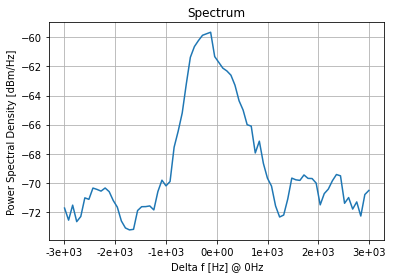

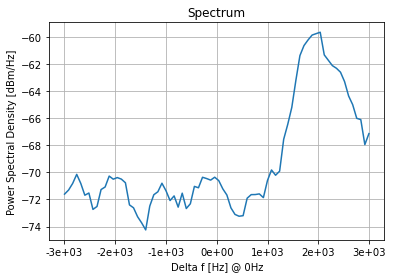

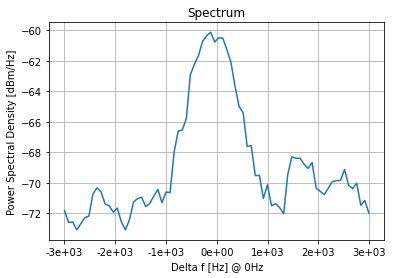

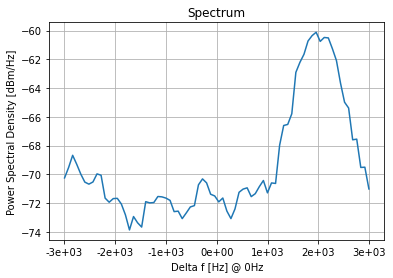

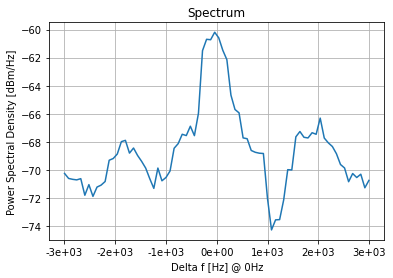

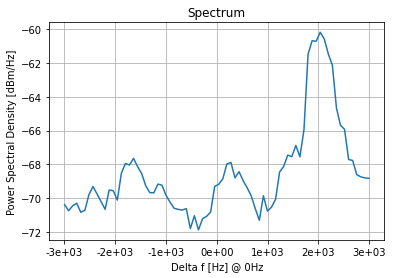

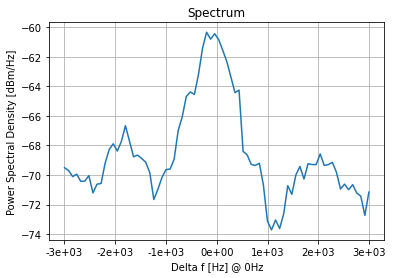

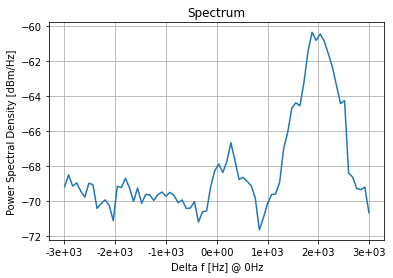

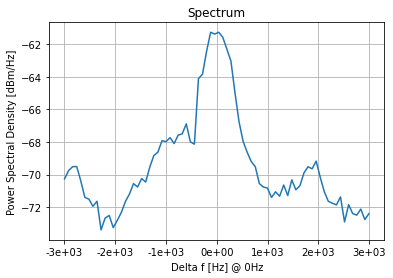

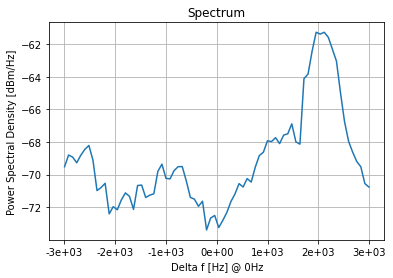

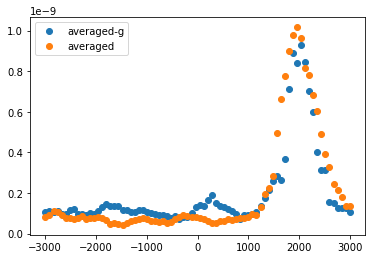

In [265]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.58.49.912.tiq')

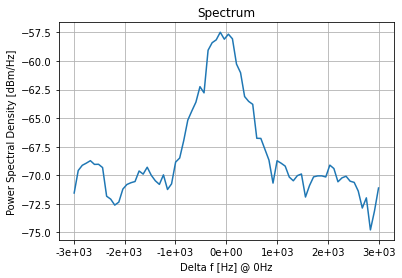

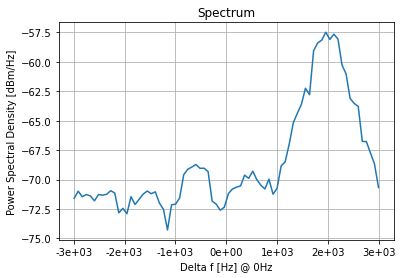

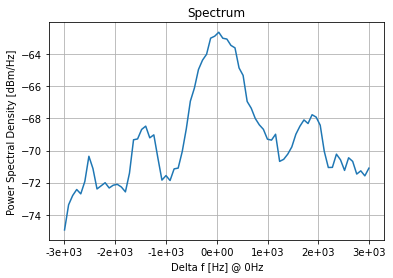

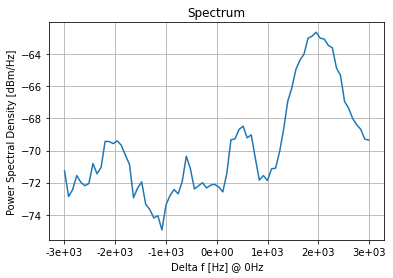

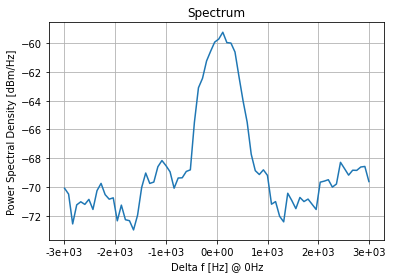

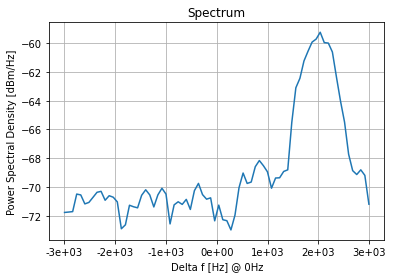

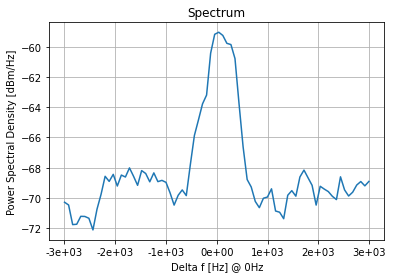

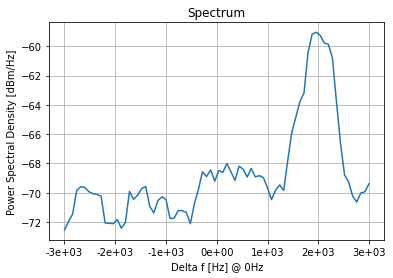

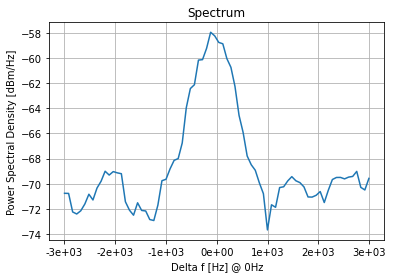

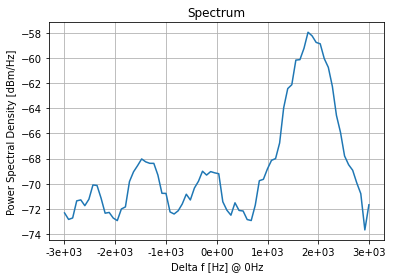

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 3
    chi-square         = 8.8133e-19
    reduced chi-square = 1.2073e-20
    Akaike info crit   = -3482.67281
    Bayesian info crit = -3475.68061
[[Variables]]
    amp:  1.3291e-06 +/- 4.0124e-08 (3.02%) (init = 6e-07)
    cen: -78.6764778 +/- 10.9569215 (13.93%) (init = 0)
    wid:  314.302745 +/- 10.9569218 (3.49%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


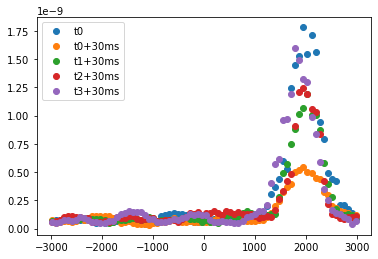

In [242]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.02.43.590.tiq')

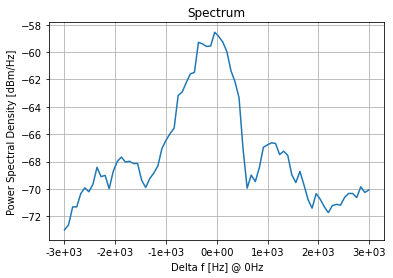

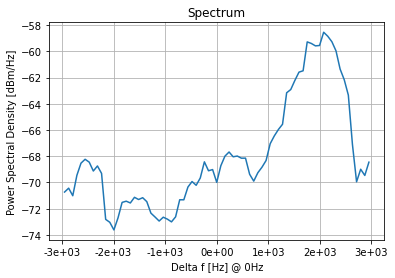

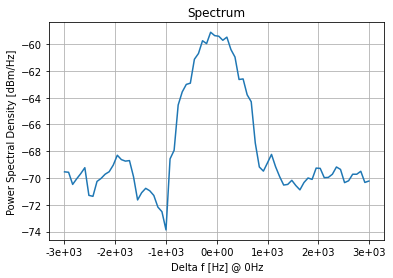

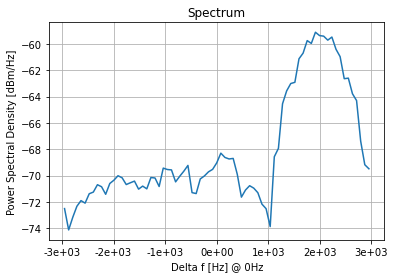

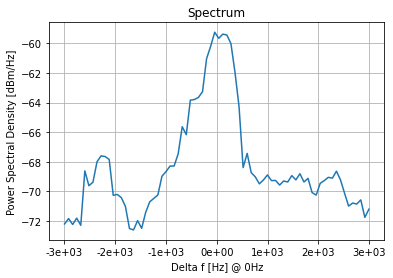

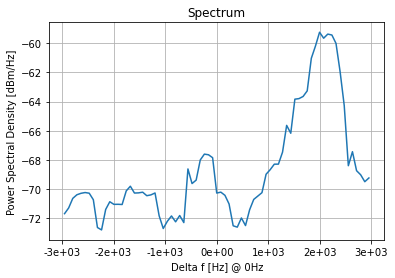

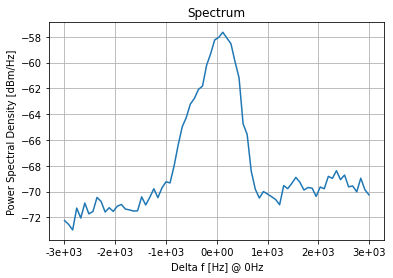

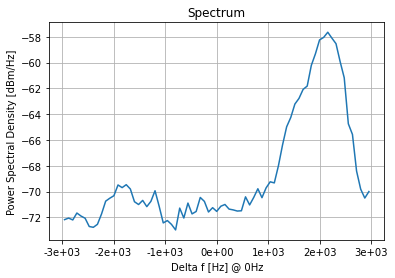

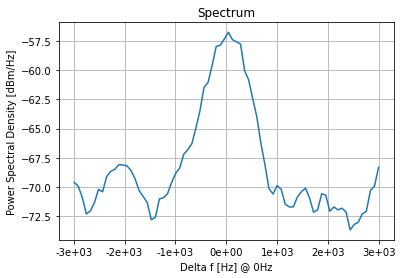

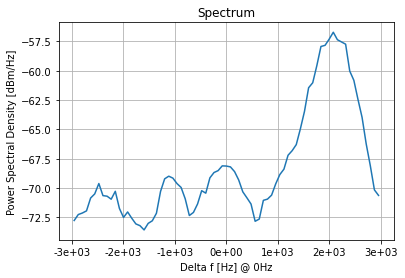

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 76
    # variables        = 3
    chi-square         = 1.0303e-18
    reduced chi-square = 1.4114e-20
    Akaike info crit   = -3470.80460
    Bayesian info crit = -3463.81240
[[Variables]]
    amp:  1.2943e-06 +/- 4.9851e-08 (3.85%) (init = 6e-07)
    cen: -117.710938 +/- 18.4602856 (15.68%) (init = 0)
    wid:  415.090510 +/- 18.4602863 (4.45%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


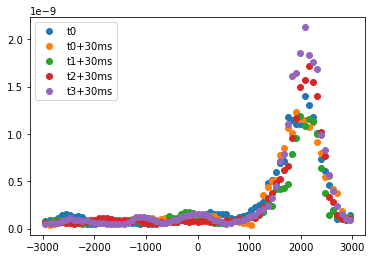

In [243]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.03.55.738.tiq')

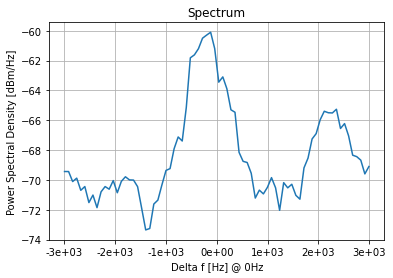

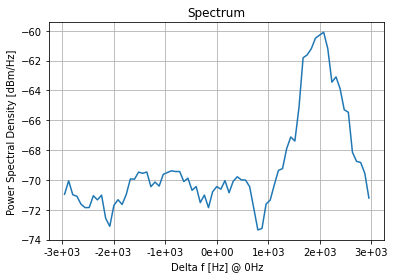

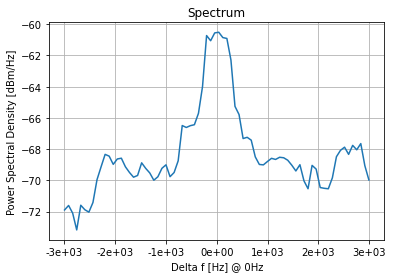

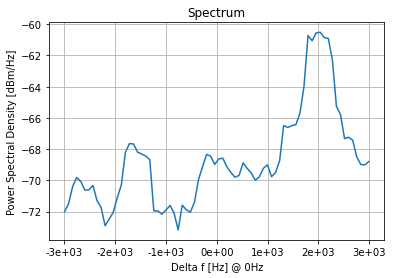

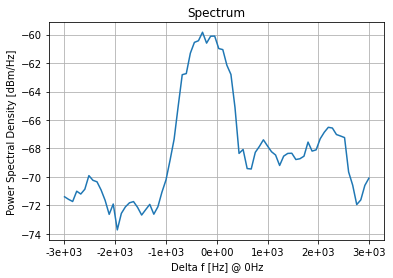

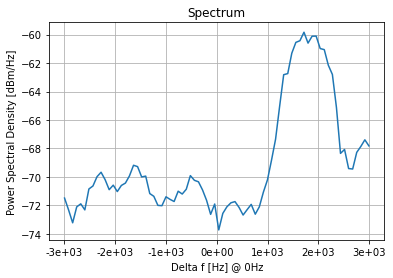

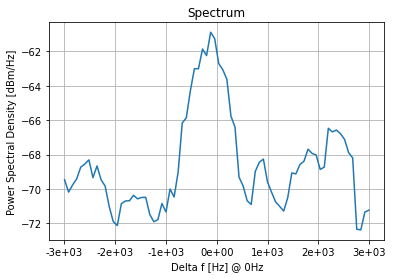

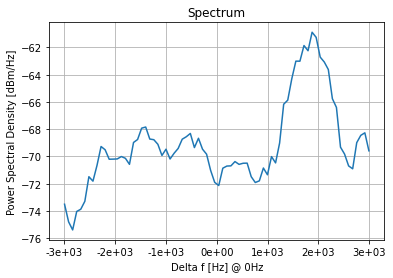

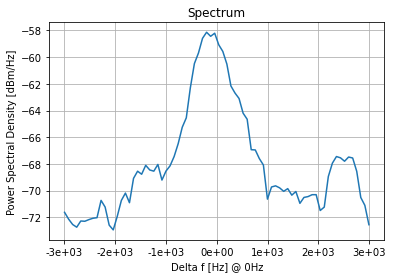

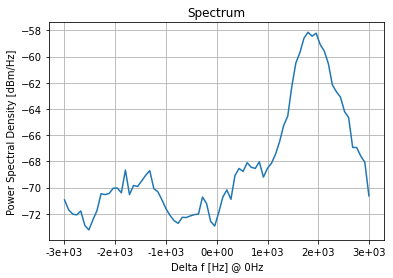

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 76
    # variables        = 3
    chi-square         = 1.1503e-18
    reduced chi-square = 1.5758e-20
    Akaike info crit   = -3462.42978
    Bayesian info crit = -3455.43758
[[Variables]]
    amp:  7.2000e-07 +/- 4.6722e-08 (6.49%) (init = 6e-07)
    cen: -205.351839 +/- 24.4673863 (11.91%) (init = 0)
    wid:  326.525931 +/- 24.4673867 (7.49%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


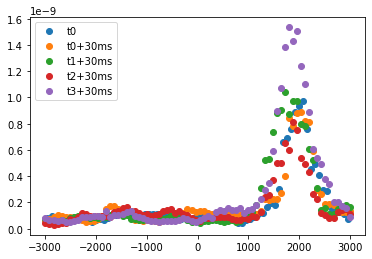

In [244]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.06.20.016.tiq')

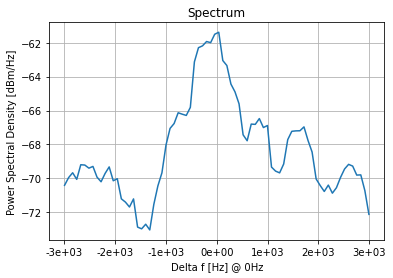

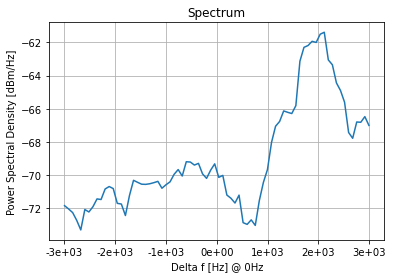

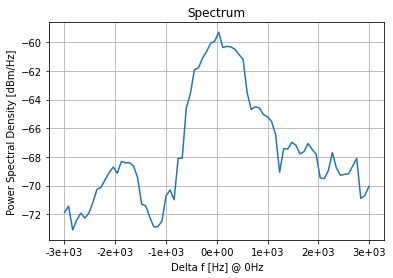

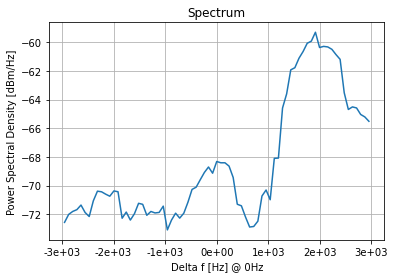

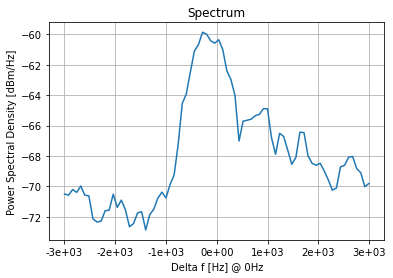

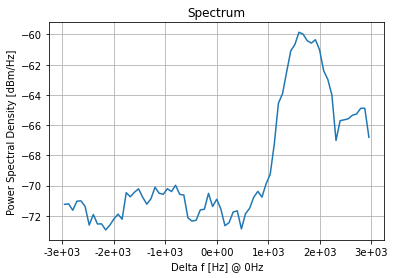

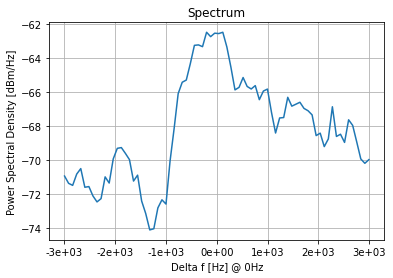

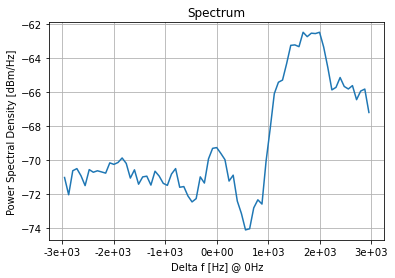

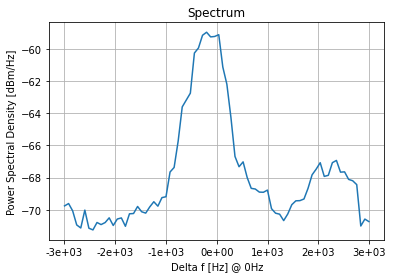

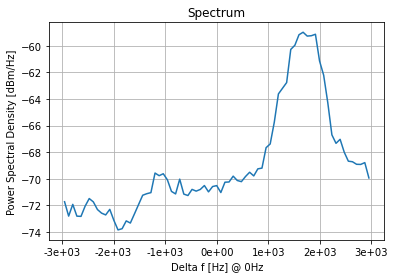

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 76
    # variables        = 3
    chi-square         = 7.5328e-19
    reduced chi-square = 1.0319e-20
    Akaike info crit   = -3494.60440
    Bayesian info crit = -3487.61220
[[Variables]]
    amp:  7.9132e-07 +/- 4.8846e-08 (6.17%) (init = 6e-07)
    cen: -80.3327892 +/- 38.8489572 (48.36%) (init = 0)
    wid:  545.074664 +/- 38.8489580 (7.13%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


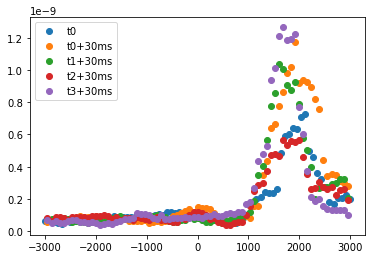

In [245]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.08.44.215.tiq')

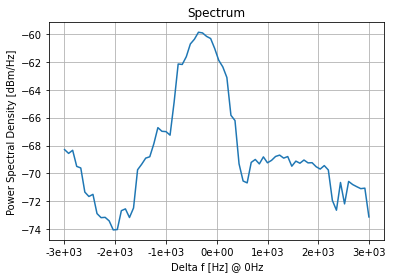

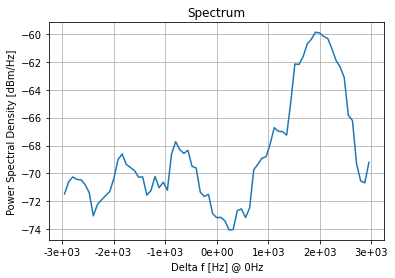

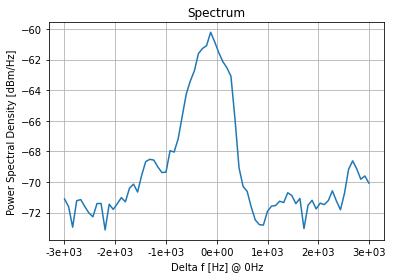

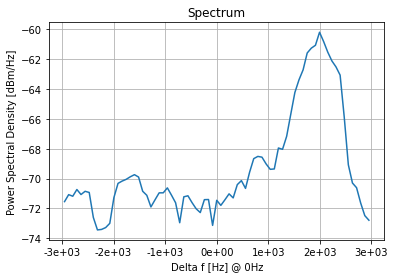

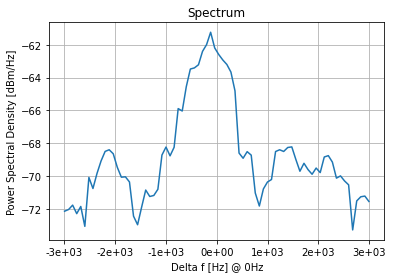

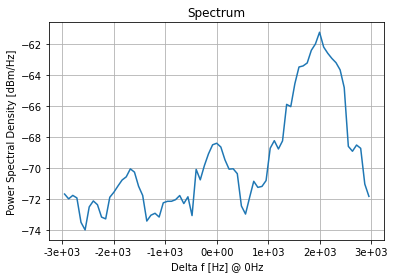

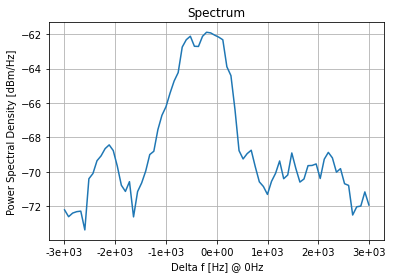

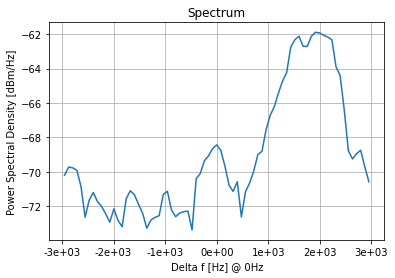

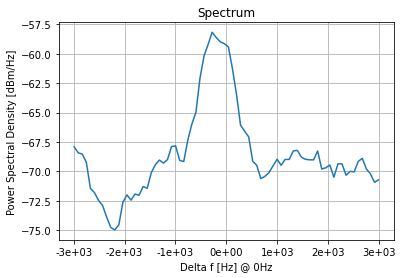

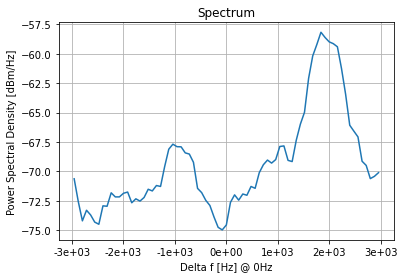

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 76
    # variables        = 3
    chi-square         = 5.6738e-19
    reduced chi-square = 7.7724e-21
    Akaike info crit   = -3516.14265
    Bayesian info crit = -3509.15045
[[Variables]]
    amp:  9.9511e-07 +/- 3.6457e-08 (3.66%) (init = 6e-07)
    cen: -302.199787 +/- 17.0508208 (5.64%) (init = 0)
    wid:  403.051270 +/- 17.0508210 (4.23%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


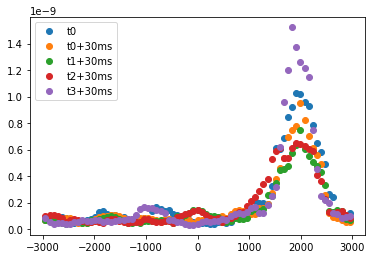

In [246]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.29.22.508.tiq')

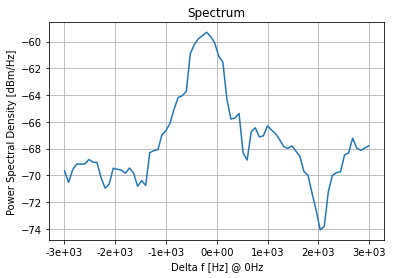

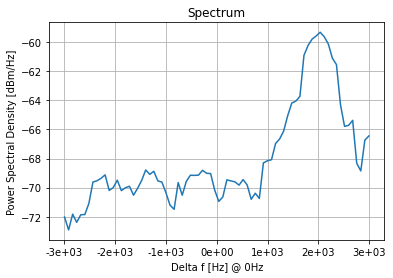

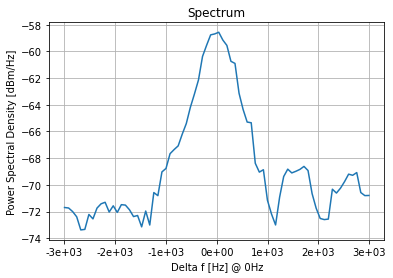

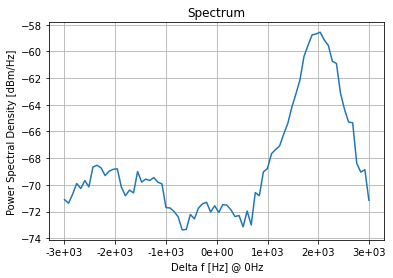

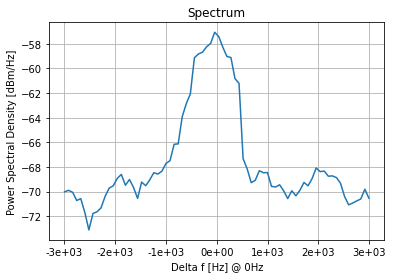

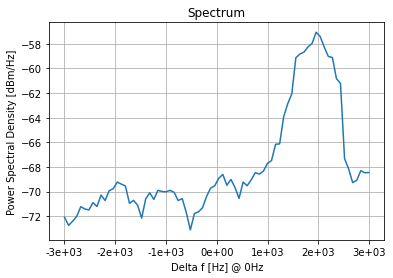

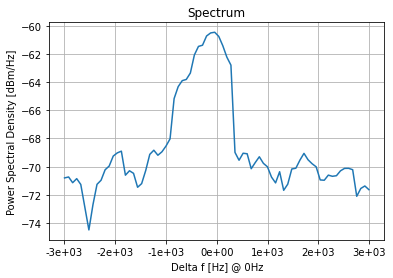

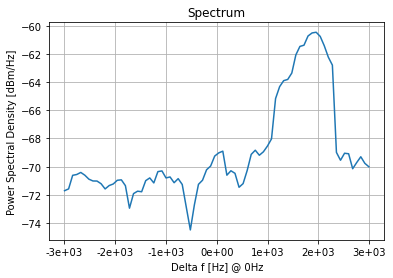

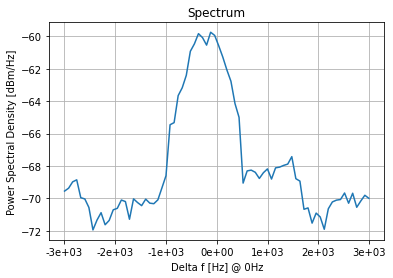

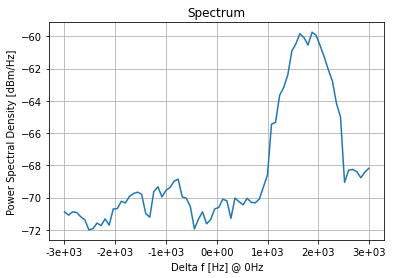

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 76
    # variables        = 3
    chi-square         = 1.1473e-18
    reduced chi-square = 1.5717e-20
    Akaike info crit   = -3462.62853
    Bayesian info crit = -3455.63633
[[Variables]]
    amp:  9.9437e-07 +/- 4.9479e-08 (4.98%) (init = 6e-07)
    cen: -231.940622 +/- 21.0950090 (9.10%) (init = 0)
    wid:  367.124857 +/- 21.0950092 (5.75%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


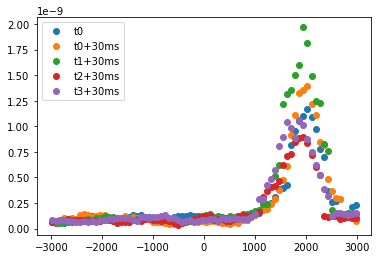

In [247]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.46.36.360.tiq')

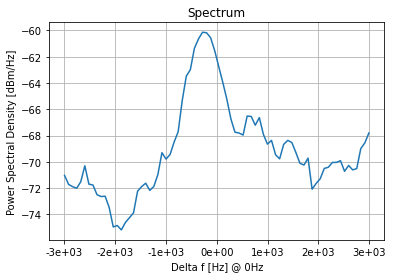

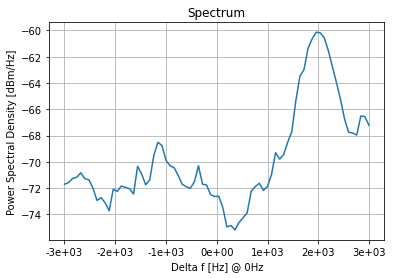

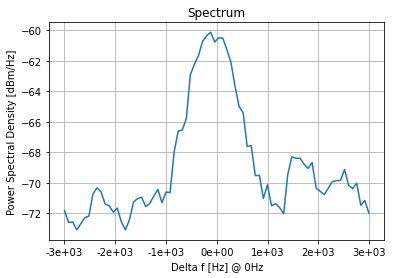

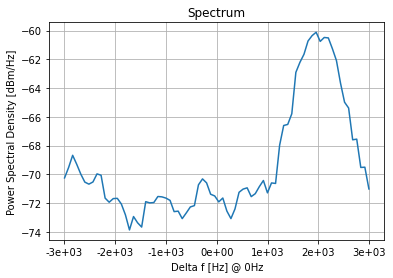

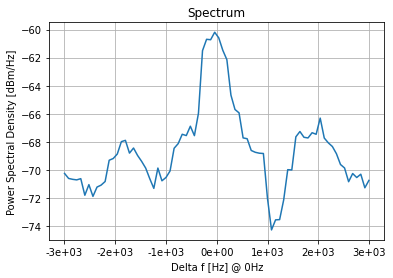

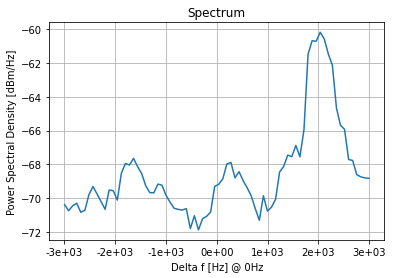

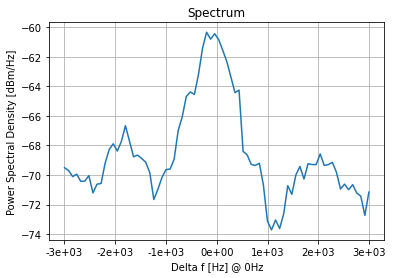

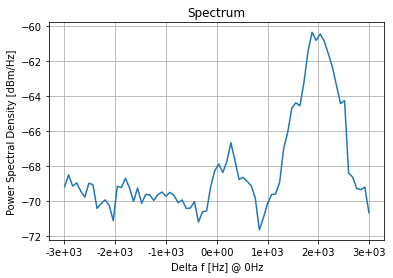

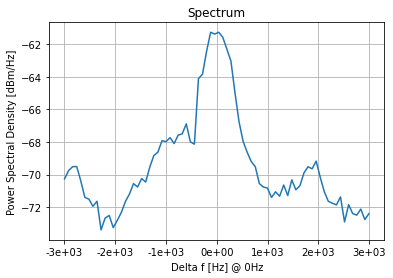

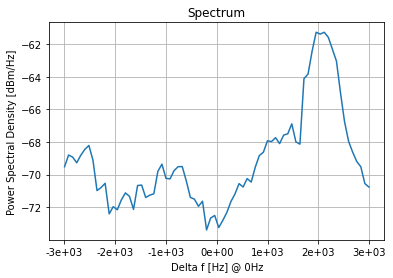

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 76
    # variables        = 3
    chi-square         = 6.6787e-19
    reduced chi-square = 9.1489e-21
    Akaike info crit   = -3503.75076
    Bayesian info crit = -3496.75856
[[Variables]]
    amp:  7.0183e-07 +/- 3.4594e-08 (4.93%) (init = 6e-07)
    cen: -235.350722 +/- 17.5486642 (7.46%) (init = 0)
    wid:  308.309697 +/- 17.5486645 (5.69%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


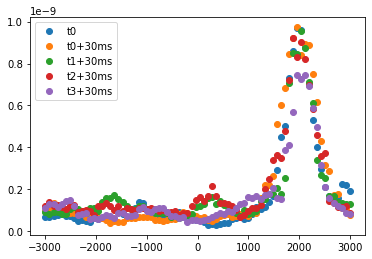

In [248]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.58.49.912.tiq')

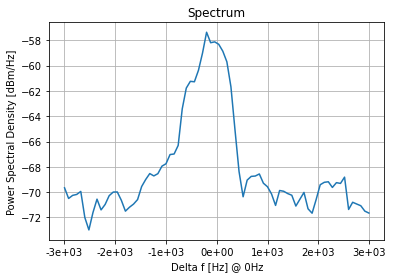

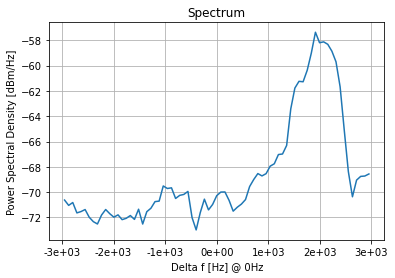

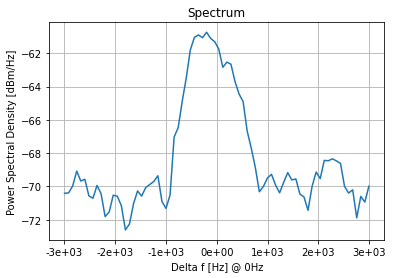

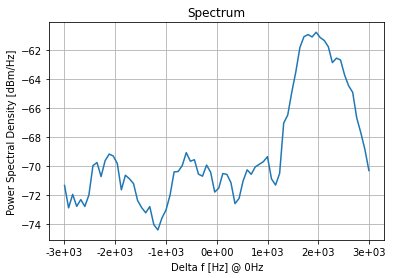

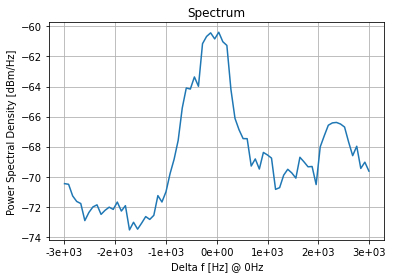

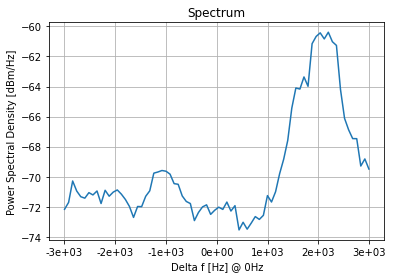

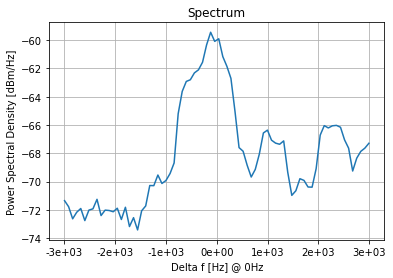

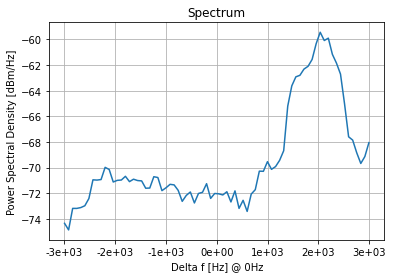

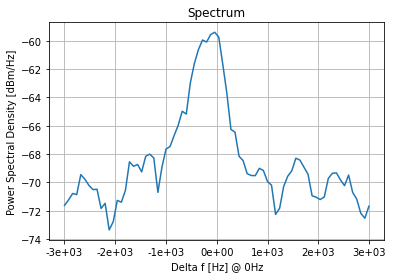

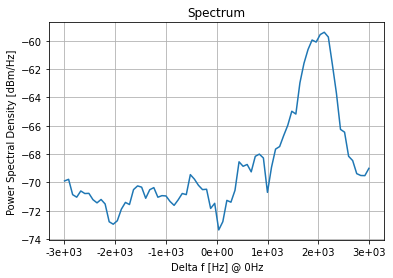

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 76
    # variables        = 3
    chi-square         = 9.5876e-19
    reduced chi-square = 1.3134e-20
    Akaike info crit   = -3476.27320
    Bayesian info crit = -3469.28100
[[Variables]]
    amp:  1.2469e-06 +/- 4.1681e-08 (3.34%) (init = 6e-07)
    cen: -116.060326 +/- 12.0349646 (10.37%) (init = 0)
    wid:  311.808643 +/- 12.0349647 (3.86%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


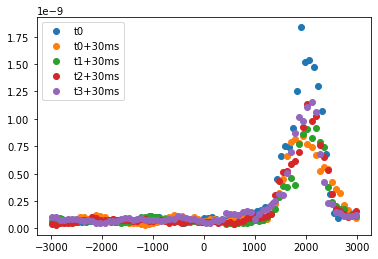

In [249]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.32.58.849.tiq')

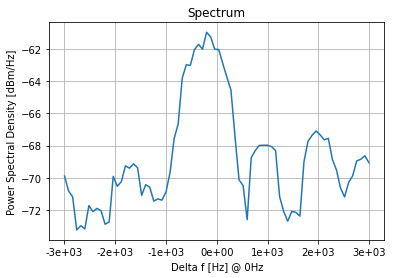

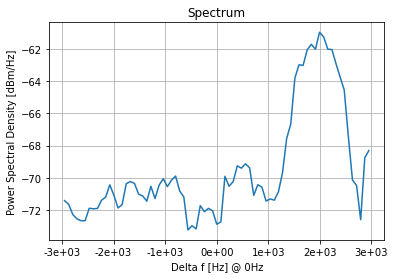

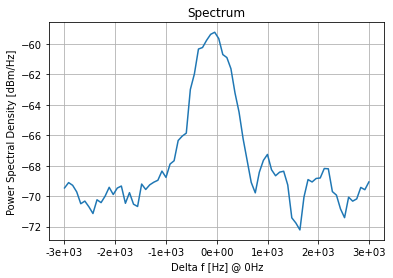

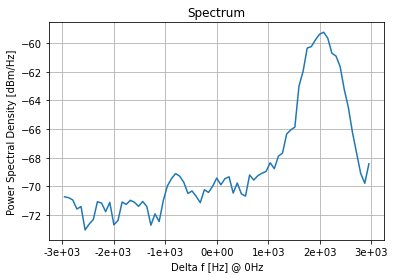

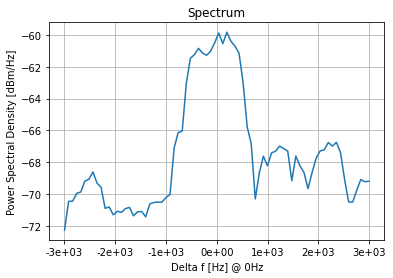

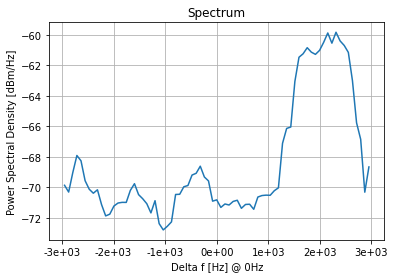

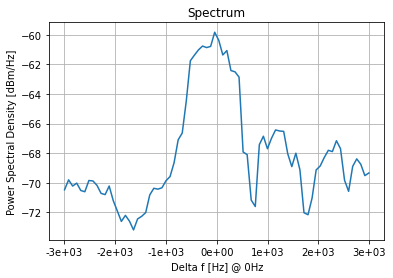

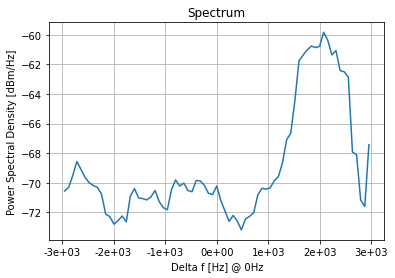

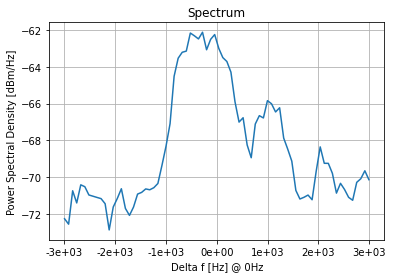

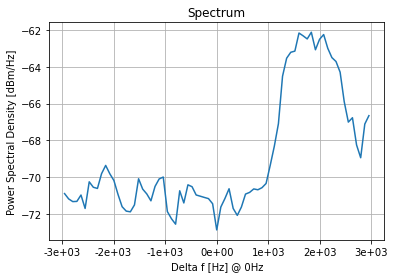

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 3
    chi-square         = 6.9345e-19
    reduced chi-square = 9.4993e-21
    Akaike info crit   = -3500.89421
    Bayesian info crit = -3493.90201
[[Variables]]
    amp:  7.2034e-07 +/- 3.9909e-08 (5.54%) (init = 6e-07)
    cen: -212.196781 +/- 25.2820582 (11.91%) (init = 0)
    wid:  395.168361 +/- 25.2820587 (6.40%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


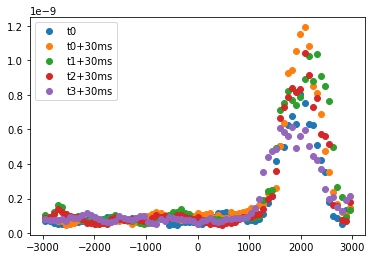

In [250]:
routine('/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.15.57.118.tiq')

# routine2

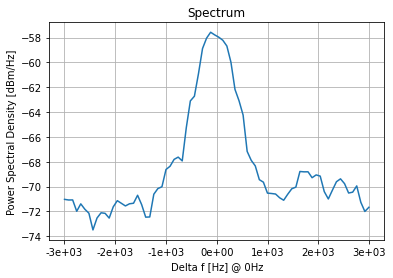

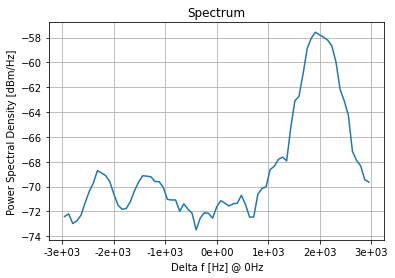

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 76
    # variables        = 3
    chi-square         = 5.6965e-19
    reduced chi-square = 7.8035e-21
    Akaike info crit   = -3515.83922
    Bayesian info crit = -3508.84702
[[Variables]]
    amp:  1.2932e-06 +/- 3.1475e-08 (2.43%) (init = 6e-07)
    cen: -31.8807846 +/- 8.40963060 (26.38%) (init = 0)
    wid:  299.231791 +/- 8.40963060 (2.81%) (init = 200)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = 0.577


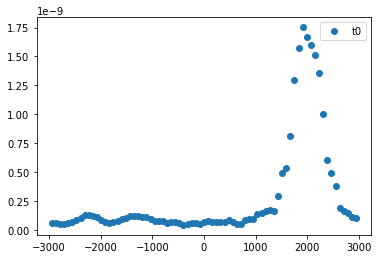

In [271]:
routine2(5.185,'/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05\
.07.06.02.43.590.tiq')

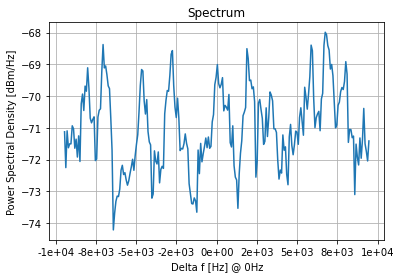

986376.572708323 142510979.19766238 6.636896362139325e-09


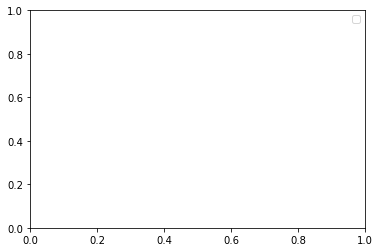

986376.572708323


IndexError: index -1 is out of bounds for axis 1 with size 0

In [412]:
routine2(8.6, '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.06.20.45.617.tiq')

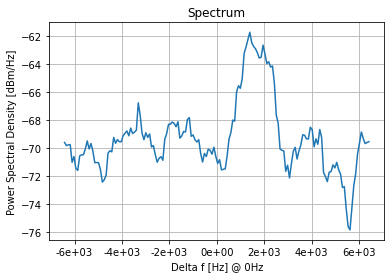

1635.5317911149389 43.19521640241688 1.1640939766549693e-08


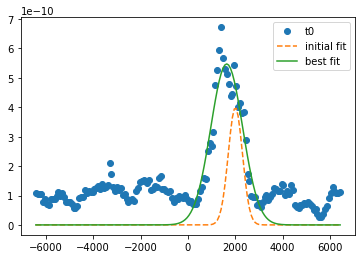

In [433]:
routine2(5.103, '/lustre/ap/litv-exp/2021-05-00_E143_TwoPhotonDeday_ssanjari/analyzers/410MHz/E143-410MHz-2021.05.07.23.\
23.34.266.tiq')

In [426]:
def routine2(t,file):
    x,y, _, _, _=isomer_substract(file,612,0.03,t,0,1.3e4)
    gmodel = Model(gaussian)
    result = gmodel.fit(y, x=x, amp=3e-07, cen=2e3, wid=3e2)
    cen=result.params['cen'].value
    plt.plot(x, y, 'o', label='t0')
    plt.plot(x, result.init_fit, '--', label='initial fit')
    plt.plot(x, result.best_fit, '-', label='best fit')
    print(cen, result.params['cen'].stderr, np.sum(y)*(x[1]-x[0])/len(y))
    plt.legend()
    #plt.savefig('2022.03.03.decay2.pdf')
    #plt.show()
    #print(cen)
    #x,y, xx1,yy1,zz1=isomer_substract(file,612,0.03,t,cen-2e3,6e3)
    #plt.plot(x, y, 'o', label='t0')
    #plt.plot(x, result.init_fit, '--', label='initial fit')
    #plt.plot(x, result.best_fit, '-', label='best fit')
    #print(cen, result.params['cen'].stderr, np.sum(y)/len(y))
    #plt.legend()
    #plt.savefig('2022.03.03.decay2.pdf')
    plt.show()